In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        # Initialize dataset with image and annotation directories and optional transform
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        # List all image files in the directory with '.jpg' extension
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]  # Get the image file name
        img_path = os.path.join(self.images_dir, img_name)  # Construct the full image path
        img = Image.open(img_path).convert("RGB")  # Open the image and convert to RGB
        img_tensor = ToTensor()(img)  # Convert the image to a tensor

        # Load annotation
        annotation_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.xml'))  # Get the corresponding annotation file path
        tree = ET.parse(annotation_path)  # Parse the XML annotation file
        root = tree.getroot()  # Get the root of the XML tree

        boxes = []  # List to store bounding boxes
        labels = []  # List to store labels
        for obj in root.findall('object'):  # Iterate over all objects in the annotation
            name = obj.find('name').text  # Get the object name
            if name != 'car':  # Skip objects that are not 'car'
                continue
            bbox = obj.find('bndbox')  # Get the bounding box
            xmin = float(bbox.find('xmin').text)  # Extract xmin
            ymin = float(bbox.find('ymin').text)  # Extract ymin
            xmax = float(bbox.find('xmax').text)  # Extract xmax
            ymax = float(bbox.find('ymax').text)  # Extract ymax
            boxes.append([xmin, ymin, xmax, ymax])  # Append the bounding box to the list
            labels.append(1)  # Label 1 for 'car' (0 is reserved for background)

        # Convert bounding boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create the target dictionary
        target = {
            "boxes": boxes,  # Bounding boxes
            "labels": labels,  # Labels
            "image_id": torch.tensor([idx]),  # Image ID
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),  # Area of each bounding box
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)  # Crowd flag (0 for no crowd)
        }

        # Apply optional transform to the image tensor
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Return the image tensor and the target dictionary
        return img_tensor, target

In [ ]:
# Define paths for images and annotations
images_dir = "data/training_images"
annotations_dir = "data/annotations"

# Copy dataset from Google Drive to Colab local storage for faster access
!cp -r "/content/drive/MyDrive/data" "/content/data"

# Update paths to point to the copied dataset in Colab local storage
images_dir = '/content/data/training_images'
annotations_dir = '/content/data/annotations'

# Create the dataset using the VOCDataset class
dataset = VOCDataset(images_dir, annotations_dir)

# Split the dataset into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))  # Calculate the size of the training set
val_size = len(dataset) - train_size  # Calculate the size of the validation set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])  # Perform the split

# Create data loaders for training and validation datasets
# Use a batch size of 2 and shuffle the training data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)
# Validation data loader does not shuffle the data
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x))
)

# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 188MB/s]


In [ ]:
num_classes = 2  # Define the number of classes: 1 class (car) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one for our specific number of classes
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer with parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)  # Use SGD with specified hyperparameters

In [ ]:
num_epochs = 10  # Number of epochs to train the model
model.train()  # Set the model to training mode
train_losses = []  # List to store training losses for each epoch
val_losses = []  # List to store validation losses for each epoch

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Ensure the model is in training mode
    epoch_train_loss = 0  # Initialize the training loss for the current epoch
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
        # Move images and targets to the device (GPU or CPU)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass to compute the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum up all the losses

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        losses.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters

        epoch_train_loss += losses.item()  # Accumulate the training loss

    # Compute the average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Append the average training loss to the list
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0  # Initialize the validation loss for the current epoch
    with torch.no_grad():  # Disable gradient computation for validation
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
            # Move images and targets to the device (GPU or CPU)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily enable training mode to compute losses
            model.train()  # Switch to training mode to compute losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())  # Sum up all the losses
            model.eval()  # Switch back to evaluation mode

            epoch_val_loss += losses.item()  # Accumulate the validation loss

    # Compute the average validation loss for the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Append the average validation loss to the list
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {avg_val_loss:.4f}")

# Save the fine-tuned model to a file
torch.save(model.state_dict(), "faster_rcnn_finetuned.pth")
print("Model saved as faster_rcnn_finetuned.pth")

Epoch 1/10 (Training): 100%|██████████| 142/142 [04:13<00:00,  1.78s/it]


Epoch 1/10, Average Training Loss: 0.1582


Epoch 1/10 (Validation): 100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epoch 1/10, Average Validation Loss: 0.1260


Epoch 2/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 2/10, Average Training Loss: 0.1037


Epoch 2/10 (Validation): 100%|██████████| 36/36 [00:10<00:00,  3.56it/s]


Epoch 2/10, Average Validation Loss: 0.1157


Epoch 3/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 3/10, Average Training Loss: 0.0885


Epoch 3/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.72it/s]


Epoch 3/10, Average Validation Loss: 0.1137


Epoch 4/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 4/10, Average Training Loss: 0.0758


Epoch 4/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.72it/s]


Epoch 4/10, Average Validation Loss: 0.1181


Epoch 5/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 5/10, Average Training Loss: 0.0683


Epoch 5/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.68it/s]


Epoch 5/10, Average Validation Loss: 0.1141


Epoch 6/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 6/10, Average Training Loss: 0.0640


Epoch 6/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.68it/s]


Epoch 6/10, Average Validation Loss: 0.1314


Epoch 7/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.69it/s]


Epoch 7/10, Average Training Loss: 0.0557


Epoch 7/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.68it/s]


Epoch 7/10, Average Validation Loss: 0.1190


Epoch 8/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 8/10, Average Training Loss: 0.0492


Epoch 8/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.70it/s]


Epoch 8/10, Average Validation Loss: 0.1192


Epoch 9/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 9/10, Average Training Loss: 0.0447


Epoch 9/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.71it/s]


Epoch 9/10, Average Validation Loss: 0.1211


Epoch 10/10 (Training): 100%|██████████| 142/142 [01:24<00:00,  1.68it/s]


Epoch 10/10, Average Training Loss: 0.0455


Epoch 10/10 (Validation): 100%|██████████| 36/36 [00:09<00:00,  3.69it/s]


Epoch 10/10, Average Validation Loss: 0.1162
Model saved as faster_rcnn_finetuned.pth


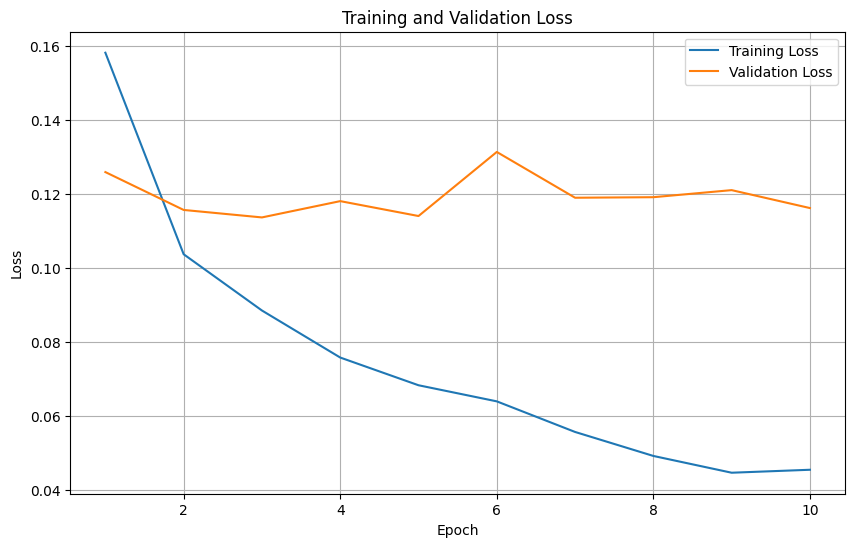

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()